In [1]:
import os
from os import walk
import copy
import pickle

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

import torch
import torchvision
from torchvision import datasets, transforms, models
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary
import torch.optim as optim

In [2]:
# check if files can be opened
print(os.listdir("./"))
    
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Using the GPU!")
else:
    print("WARNING: Could not find GPU! Using CPU only. If you want to enable GPU, please to go Edit > Notebook Settings > Hardware Accelerator and select GPU.")

data_dir = "./data_miniplaces_modified"

['.DS_Store', 'test_v1.pth', 'data_32', 'data_256', 'README.md', '.gitignore', '351.ipynb', '.ipynb_checkpoints', '.git']
PyTorch Version:  2.0.0
Torchvision Version:  0.15.0


In [4]:
calc_transform = transforms.Compose([transforms.ToTensor()])
calc_dataset = datasets.ImageFolder("./data_256/art_pictures/train",
                               transform=calc_transform)
# dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

In [6]:
calc_loader = torch.utils.data.DataLoader(calc_dataset)

#pre-process data: only need to be done once
psum    = torch.tensor([0.0, 0.0, 0.0])
psum_sq = torch.tensor([0.0, 0.0, 0.0])

# loop through images
for data in tqdm(calc_loader):
    psum    += data[0].sum(axis        = [0, 2, 3])
    psum_sq += (data[0] ** 2).sum(axis = [0, 2, 3])


    
# calculate the total num of pixels
count = len(calc_loader.dataset) * 256 * 256

# mean and std
total_mean = psum / count
total_var  = (psum_sq / count) - (total_mean ** 2)
total_std  = torch.sqrt(total_var)

# output
print('mean: '  + str(total_mean))
print('std:  '  + str(total_std))

# here are the results
# mean: tensor([0.5162, 0.4644, 0.3975])
# std:  tensor([0.2728, 0.2641, 0.2575])


100%|████████████████████████████████████| 50000/50000 [01:08<00:00, 725.59it/s]

mean: tensor([0.5162, 0.4644, 0.3975])
std:  tensor([0.2728, 0.2641, 0.2575])


In [8]:
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize([0.5162, 0.4644, 0.3975], [0.2728, 0.2641, 0.2575])])
dataset = datasets.ImageFolder("./data_256/art_pictures/train",
                               transform=calc_transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True, num_workers=2)

In [9]:
labels_map = {
    0: "art_nouveau",
    1: "baroque",
    2: "expressionism",
    3: "impressionism",
    4: "post_impressionism",
    5: "realism",
    6: "renaissance",
    7: "romanticism",
    8: "surrealism",
    9: "ukiyo_e",
}

In [10]:
# Get one batch
images, labels = next(iter(dataloader))

In [11]:
images[1].size()

torch.Size([3, 256, 256])

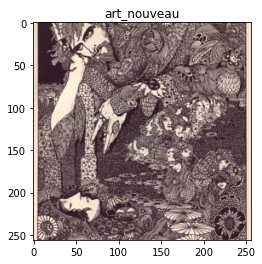

In [14]:
# see some pictures
some_index = 2
plt.title(labels_map[labels[some_index].item()])
plt.imshow(images[some_index].permute(1,2,0))

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(59536, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [27]:
summary(net, input_size = (32, 3, 256, 256))

/Users/zijunning/opt/anaconda3/lib/python3.9/site-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/Users/zijunning/opt/anaconda3/lib/python3.9/site-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [32, 10]                  --
├─Conv2d: 1-1                            [32, 6, 252, 252]         456
├─MaxPool2d: 1-2                         [32, 6, 126, 126]         --
├─Conv2d: 1-3                            [32, 16, 122, 122]        2,416
├─MaxPool2d: 1-4                         [32, 16, 61, 61]          --
├─Linear: 1-5                            [32, 120]                 7,144,440
├─Linear: 1-6                            [32, 84]                  10,164
├─Linear: 1-7                            [32, 10]                  850
Total params: 7,158,326
Trainable params: 7,158,326
Non-trainable params: 0
Total mult-adds (G): 2.31
Input size (MB): 25.17
Forward/backward pass size (MB): 158.56
Params size (MB): 28.63
Estimated Total Size (MB): 212.36

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [28]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

Finished Training


In [29]:
PATH = './test_v1.pth'
torch.save(net.state_dict(), PATH)

In [30]:
test_set = datasets.ImageFolder("/Users/zijunning/Documents/EECS_351/data_256/art_pictures/test",
                               transform=transform)
testloader = torch.utils.data.DataLoader(dataset, shuffle=True)

In [32]:
dataiter = iter(testloader)

In [39]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        test_images, test_labels = data
        # calculate outputs by running images through the network
        outputs = net(test_images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += test_labels.size(0)
        correct += (predicted == test_labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 10 %
